In [44]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op

In [2]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

### Model

In [41]:
N = 3
nBins = N
obs = jnp.array([70.]*N)
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N,[45]*N,[55]*N)

n_samples = 100_000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

In [42]:
# Truth
model.expected_actualdata([0., 2.])

Array([70., 70., 70.], dtype=float64)

In [45]:
expData_op = make_op.make_op(model)

### Simple Inference

In [6]:
post_data, post_pred, prior_pred = one_line_inference.sampling(prepared_model, draws=1000, chains=1, step_method='NUTS_with_jitter', tune=1000 )

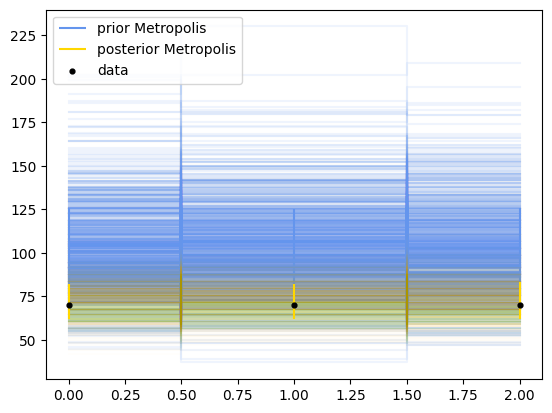

In [5]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.1, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='prior Metropolis');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'gold', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'gold', label='posterior Metropolis')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'')

plt.show()

### Parameter Correlation for Different Backgrounds

In [5]:
post_data, post_pred, prior_pred = one_line_inference.sampling(prepared_model, expData_op, draws=1000, chains=1, step_method='NUTS_with_advi', tune=1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Initializing NUTS using advi...


Convergence achieved at 6300
Interrupted at 6,299 [3%]: Average Loss = 20.128
Interrupted at 6,299 [3%]: Average Loss = 20.128


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


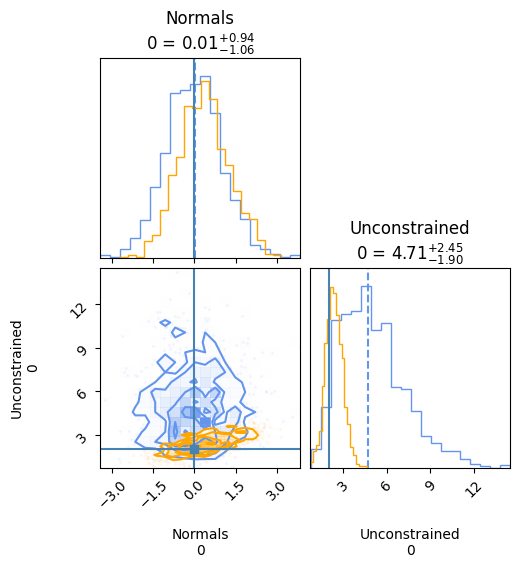

In [8]:
# Parameter Corner Plots
a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, color='cornflowerblue')
corner.corner(post_data.posterior, color = 'orange', truths=[0., 2.], fig=a);

### Traces

In [11]:
post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=10_000, chains=1, step_method='Metropolis', tune=1000 )

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>]], dtype=object)

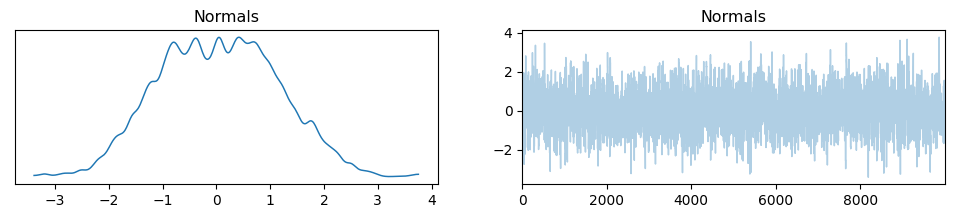

In [12]:
pm.plot_trace(post_data.posterior.Normals)

### Convergence Posterior to Prior
Bin counts:

In [124]:
obs_from_prior = obs
iterations = 1
n_samples = 100

post_normals = []
post_unconstrained = []
post_exp = []

import random

for i in range(iterations):
    post_data, post_pred, prior_pred = actual_inference.sampling(prepared_model, expData_op, draws=n_samples, chains=1, step_method='NUTS_with_advi', tune=1000 )

    # Generating pseudo-data from prior and update the prepared_model
    ii = randint(0, 100 - 1)
    obs_from_prior = prior_pred.prior_predictive.Expected_Data[0][ii] 
    prepared_model = prepare_inference.prepare_model(model=model, observations=obs_from_prior, priors=prior_dict)

    # Fill arrays
    post_exp.append(np.asarray(post_pred.posterior_predictive.Expected_Data[0]))
    # post.append(np.asarray(post_data.Normals))


all_post_averages = []

for i in range(iterations):
    exp_iteration = np.full(nBins, 0)
    for n in range(n_samples):
        exp_iteration = exp_iteration + post_exp[i][n]

    all_post_averages.append(exp_iteration/np.full(nBins, n_samples))


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 9500
Interrupted at 9,499 [4%]: Average Loss = 18.904
Interrupted at 9,499 [4%]: Average Loss = 18.904


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'black', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'black', label='init-prior', zorder=1900);

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),np.asarray(all_post_averages[i]).T, alpha = 0.5, c = 'cornflowerblue', where = 'mid', label='Posteriors from pseudo-data, averaged over all draws')


for i in np.linspace(1, int(iterations-1), int(iterations-1), dtype=int):
    plt.step(np.linspace(0,nBins-1,nBins),np.asarray(all_post_averages[i]).T, alpha = 0.2, c = 'cornflowerblue', where = 'mid')

plt.title('NUTS with init=advi')
plt.legend(loc='upper left')

Parameters:

In [303]:
def prior_pars_data(n_samples):
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)

                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars))
                
                prior_pred = pm.sample_prior_predictive(n_samples)

        return np.array(prior_pred.prior.Normals[0]), np.array(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior.Expected_Data[0])

def posterior_from_prior(prior_data, n_samples):
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)

                
                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars), observed=prior_data)
                
                step1 = pm.Metropolis()
                post_data = pm.sample(n_samples, chains=1, init='advi')
                post_pred = pm.sample_posterior_predictive(post_data)

        return np.array(post_data.posterior.Normals[0]), np.array(post_data.posterior.Unconstrained[0]), np.array(post_pred.posterior_predictive.Expected_Data[0][0])
        

In [304]:
prior_Normals, prior_Unconstrained, prior_data = prior_pars_data(500)

Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
post_n, post_u, post_d = [], [], []
count = 0
for p_d in prior_data:
    count += 1
    print(f'STEP:  {count}')
    a, b, c = posterior_from_prior(p_d, 1)
    post_n.append(a)
    post_u.append(b)
    post_d.append(c)

In [6]:
post_Normals, post_Unconstrained, post_data = [], [], []
for a in post_n:
    post_Normals.append(a)
post_Normals = np.concatenate(post_Normals)

for b in post_u:
    post_Unconstrained.append(b)
post_Unconstrained = np.concatenate(post_Unconstrained)

for c in post_d:
    post_data.append(c)
post_data = np.concatenate(post_data)

NameError: name 'post_n' is not defined

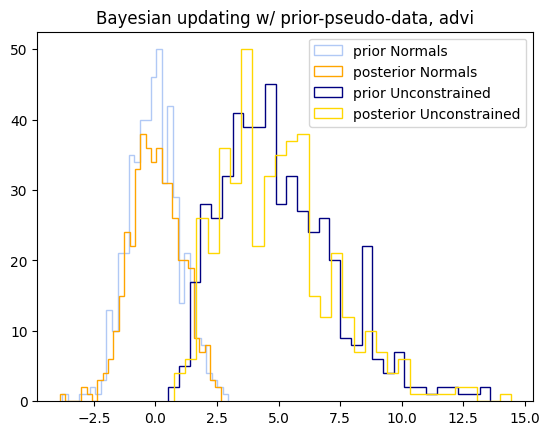

In [313]:
plt.hist(prior_Normals, 30, histtype='step', alpha = 0.5, color='cornflowerblue', label='prior Normals')
plt.hist(post_Normals, 30, histtype='step', color='orange', label='posterior Normals')

plt.hist(prior_Unconstrained, 30, histtype='step', color='navy', label='prior Unconstrained')
plt.hist(post_Unconstrained, 30, histtype='step', color='gold', label='posterior Unconstrained')

plt.legend()
plt.title('Bayesian updating w/ prior-pseudo-data, advi')
plt.show()

# plt.hist(prior_data, histtype='step', label='prior data')
# plt.hist(post_data, histtype='step', label='posterior data')

### Autocorrelation and Thinning

In [29]:
post_data, post_pred, prior_pred = one_line_inference.sampling(prepared_model, draws=4000, chains=1, step_method='NUTS_with_jitter', tune=1000 )

/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (4000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [14]:
thinned_posterior = post_data.posterior.thin(6)

In [ ]:
az.plot_autocorr(post_data)
az.plot_autocorr(thinned_posterior)

plt.show()

array([<AxesSubplot: title={'center': 'Normals\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
       <AxesSubplot: title={'center': 'Unconstrained\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
      dtype=object)

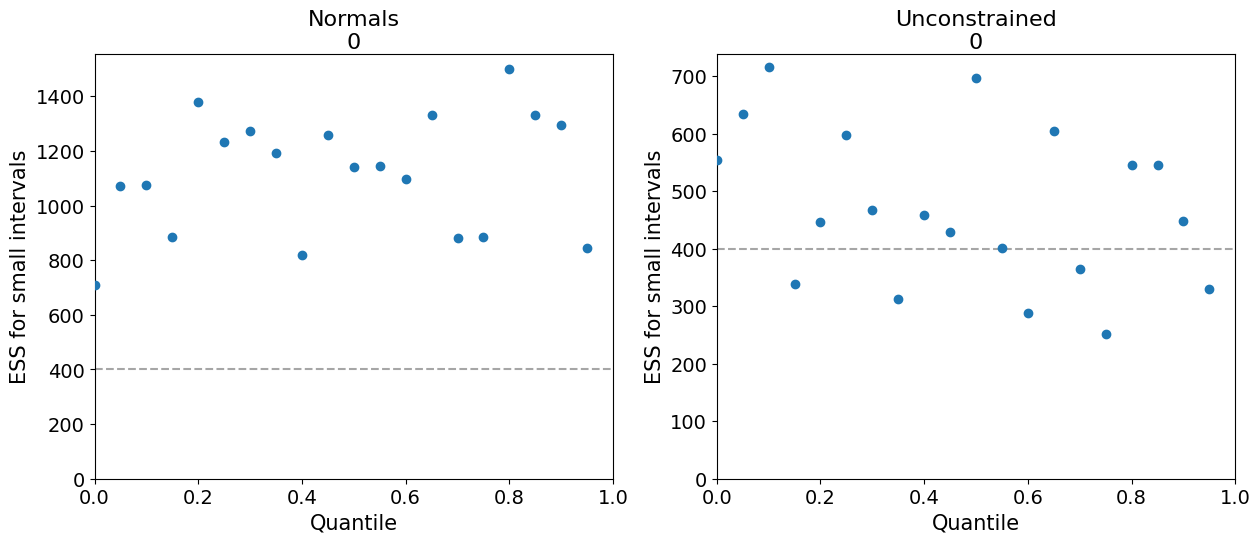

In [23]:
az.plot_ess(post_data.posterior)

array([<AxesSubplot: title={'center': 'Normals\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
       <AxesSubplot: title={'center': 'Unconstrained\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
      dtype=object)

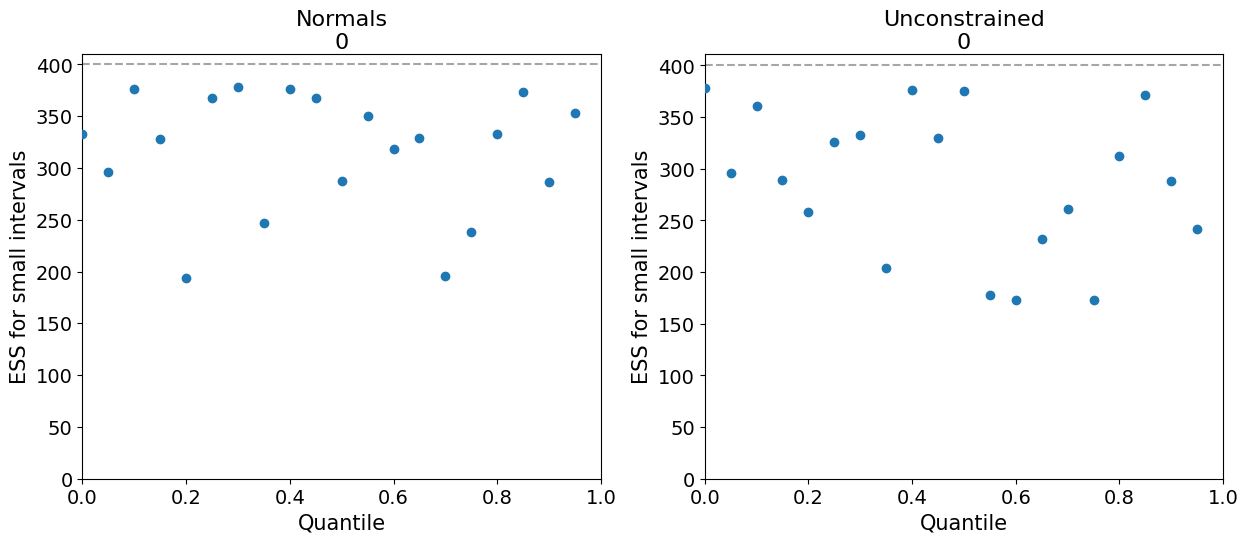

In [24]:
az.plot_ess(post_data.posterior.thin(12))

array([<AxesSubplot: title={'center': 'Normals\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
       <AxesSubplot: title={'center': 'Unconstrained\n0'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

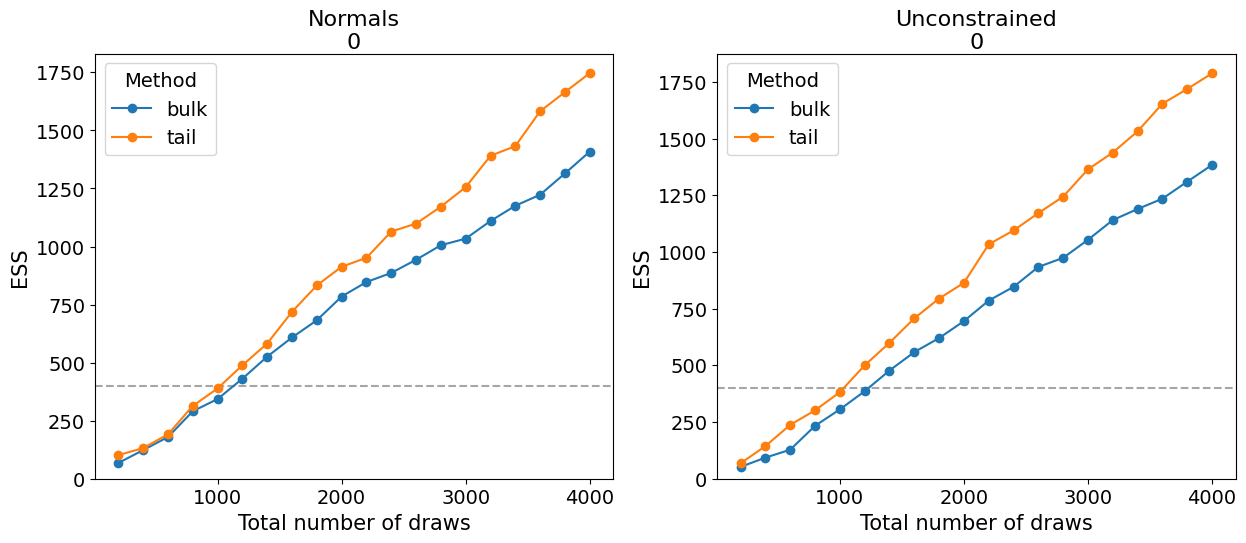

In [30]:
az.plot_ess(
    post_data, kind="evolution",
)

## Testing other stuff

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dask

from pyhf_pymc import context_inference

In [150]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    prior_pred = pm.sample_prior_predictive(30)

prior_Normals, prior_Unconstrained, prior_data = np.concatenate(prior_pred.prior.Normals[0]), np.concatenate(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior_predictive.Expected_Data[0])

Sampling: [Expected_Data, Normals, Unconstrained]


In [151]:
with open('parallel/prior_Normals_Metropolis.txt', 'w') as filehandle:
    json.dump(prior_Normals.tolist(), filehandle)
with open('parallel/prior_Unconstrained_Metropolis.txt', 'w') as filehandle:
    json.dump(prior_Unconstrained.tolist(), filehandle)

In [162]:
with pm.Model():
    pm.Poisson('a', 30)

In [158]:
def posterior_from_prior(prior_data):
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)
                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars), observed=prior_data)
                
                step1 = pm.Metropolis()
                post_data = pm.sample(1, chains=1, step=step1, tune=1000)
                post_pred = pm.sample_posterior_predictive(post_data)

        return [np.concatenate(post_data.posterior.Normals[0]), np.concatenate(post_data.posterior.Unconstrained[0]), np.array(post_pred.posterior_predictive.Expected_Data[0][0])]

In [ ]:
# Call function three times
post = []
for p_d in prior_data:
    a = dask.delayed(posterior_from_prior)(p_d)
    post.append(a)

graph = dask.delayed()(post)
computed_list = graph.compute()


Only 1 samples in chain.
Only 1 samples in chain.
Only 1 samples in chain.


NotImplementedError: These `Op`s should be removed from graphs used for computation.
Apply node that caused the error: TransformedVariable(Elemwise{exp,no_inplace}.0, Unconstrained_log__)
Toposort index: 2
Inputs types: [TensorType(float64, (1,)), TensorType(float64, (1,))]
Inputs shapes: [(1,), (1,)]
Inputs strides: [(8,), (8,)]
Inputs values: [array([5.]), array([1.60943791])]
Outputs clients: [[InplaceDimShuffle{}(Unconstrained_log___log)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Elemwise{add,no_inplace}(TensorConstant{(1,) of 1}, Expected_Data{[87 70 77]})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pytensor/graph/rewriting/basic.py", line 1925, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pytensor/graph/rewriting/basic.py", line 1084, in transform
    return self.fn(fgraph, node)
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pytensor/tensor/rewriting/basic.py", line 1141, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib

In [ ]:
delayed_post_Normals = []
delayed_post_Unconstrained = []
delayed_post_data = []
for i in range(len(prior_data)):
    a = post_Normals[i].compute()
    delayed_post_Normals.append(a)

    b = post_Unconstrained[i].compute()
    delayed_post_Unconstrained.append(b)

    c = post_Unconstrained[i].compute()
    delayed_post_Unconstrained.append(c)

print(delayed_post_Normals)
print(delayed_post_Unconstrained)
print(delayed_post_data)

Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


KeyboardInterrupt: 

Only 1 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


In [69]:
# post_Normals, post_Unconstrained, post_data = [], [], []
# i = 0

for p_d in p_d0:
    a, b, c = posterior_from_prior(p_d)
    post_Normals.append(a[0])
    post_Unconstrained.append(b[0])
    post_data.append(c[0])

    with open('parallel/post_Normals_Metropolis.txt', 'a') as file:
        file.write(f'{a[0]}, ')

    with open('parallel/post_Unconstrained_Metropolis.txt', 'a') as file:
        file.write(f'{b[0]}, ')

    # print(f'STEP: {i}')
    # i += 1




TypeError: Delayed objects of unspecified length are not iterable

In [66]:
output.visualize()

NameError: name 'output' is not defined

In [57]:
@dask.delayed
def make_posteriors(prior_data):
    post_Normals, post_Unconstrained, post_data = [], [], []
    i = 0
    for p_d in prior_data:
        a, b, c = posterior_from_prior(p_d)
        post_Normals.append(a[0])
        post_Unconstrained.append(b[0])
        post_data.append(c[0])

        with open('parallel/post_Normals_Metropolis.txt', 'a') as file:
            file.write(f'{post_Normals[i]}, ')

        with open('parallel/post_Unconstrained_Metropolis.txt', 'a') as file:
            file.write(f'{post_Unconstrained[i]}, ')

        print(f'STEP: {i}')
        i += 1


In [63]:
a = make_posteriors(prior_data)

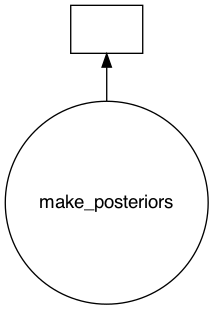

Only 1 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.
/var/folders/p9/sw_pjm3j027cxfs57s_91bfw0000gn/T/ipykernel_8648/4291106093.py:7: UserWarning: The number of samples is too small to check convergence reliably.
  post_data = pm.sample(1, chains=1, step=step1, tune=1000)


STEP: 4


In [ ]:
a.visualize()

In [ ]:
a.compute()

Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 0


Only 1 samples in chain.


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.


STEP: 1


KeyboardInterrupt: 

Only 1 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]


Sampling 1 chain for 1_000 tune and 1 draw iterations (1_000 + 1 draws total) took 0 seconds.
/var/folders/p9/sw_pjm3j027cxfs57s_91bfw0000gn/T/ipykernel_8648/4291106093.py:7: UserWarning: The number of samples is too small to check convergence reliably.
  post_data = pm.sample(1, chains=1, step=step1, tune=1000)


STEP: 2
